# Background



In [1]:
import bayesld
import tempfile, subprocess
import pandas as pd
def process(ts, recombination_rate):
    # Use a temporary directory for intermediate files
    with tempfile.TemporaryDirectory() as tmpdir:
        trees_path = f"{tmpdir}/example.trees"
        bcf_path = f"{tmpdir}/example.bcf"

        # Dump tree sequence
        ts.dump(trees_path)

        # Run tskit -> bcftools pipeline
        subprocess.run(
            f"tskit vcf --allow-position-zero {trees_path} | bcftools view -O b > {bcf_path}",
            shell=True,
            check=True
        )

        # Index BCF
        subprocess.run(
            ["bcftools", "index", bcf_path],
            check=True
        )

        # Compute LD
        mean, variance, n, left, right = bayesld.compute_ld(bcf_path, "1", recombination_rate)

    return pd.DataFrame({'mean':mean, 'variance':variance, 'n' : n, 'left' : left / 100, 'right' : right / 100})

def simulate_data():
    import msprime
    theta = [2000]
    n_samples = 20
    RECOMBINATION_RATE = MUTATION_RATE = 1e-8
    CONTIG_LENGTH = 1e8
    seed = 1234
    demography = msprime.Demography()
    demography.add_population(name="p0", initial_size=theta[0])
    replicates = msprime.sim_ancestry(
            samples={"p0" : n_samples},
            recombination_rate=RECOMBINATION_RATE,
            sequence_length=CONTIG_LENGTH,
            random_seed=seed,
            demography=demography,
            num_replicates=10
        )
    for i, ts in enumerate(replicates):
        mts = msprime.sim_mutations(ts, rate = MUTATION_RATE, random_seed=seed+i)
        res =  process(mts, RECOMBINATION_RATE).assign(seed=i)
        yield res



In [2]:
df = pd.concat(x for x in simulate_data())
data = df.pivot(index='seed', columns='left', values='mean').to_numpy()

In [11]:
n_samples = 20

In [12]:
import pymc as pm
import seaborn as sns
import bayesld
import bayesld.models
import arviz as az
empirical_sigma = data.std(ddof=1, axis=0)
left, right = df.left.unique(), df.right.unique()
with pm.Model() as model:
    Ne = pm.Uniform("Ne", 0, 5000)
    LD = pm.Deterministic("LD", bayesld.models.expected_ld_constant(Ne, left, right, sample_size=n_samples))
    pm.Normal("likelihood", LD, empirical_sigma, observed = data)
    trace = pm.sample()

az.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ne,2153.438,50.089,2062.614,2250.377,1.189,0.74,1770.0,2824.0,1.0
LD[0],0.020,0.000,0.019,0.021,0.000,0.00,1770.0,2824.0,1.0
LD[1],0.013,0.000,0.013,0.013,0.000,0.00,1770.0,2824.0,1.0
LD[2],0.010,0.000,0.010,0.010,0.000,0.00,1770.0,2824.0,1.0
LD[3],0.008,0.000,0.008,0.009,0.000,0.00,1770.0,2824.0,1.0
LD[4],0.007,0.000,0.007,0.008,0.000,0.00,1770.0,2824.0,1.0
LD[5],0.007,0.000,0.006,0.007,0.000,0.00,1770.0,2824.0,1.0
LD[6],0.006,0.000,0.006,0.006,0.000,0.00,1770.0,2824.0,1.0
LD[7],0.006,0.000,0.006,0.006,0.000,0.00,1770.0,2824.0,1.0
LD[8],0.005,0.000,0.005,0.005,0.000,0.00,1770.0,2824.0,1.0


array([[<Axes: title={'center': 'Ne'}>, <Axes: title={'center': 'Ne'}>],
       [<Axes: title={'center': 'LD'}>, <Axes: title={'center': 'LD'}>]],
      dtype=object)

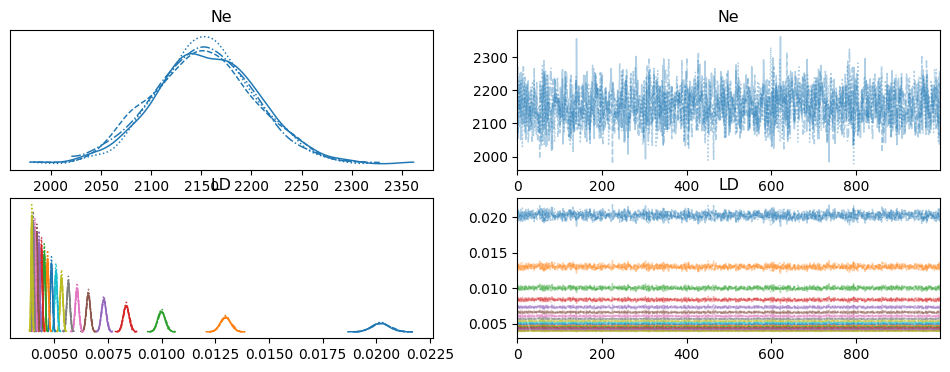

In [13]:
az.plot_trace(trace)

In [54]:
data[:, 0].mean()

np.float64(0.0211339340692203)

In [58]:
# Expected r^2 for constant Ne model
import numpy as np
def expected_r2(u_i, u_j, Ne):
    return (-np.log(4 * Ne * u_i + 1) + np.log(4 * Ne * u_j + 1)) / (
        4 * Ne * (u_j - u_i)
    )
# Correction for finite sample size
def correct_r2(mu, sample_size):
    S = sample_size * 2
    beta = 1 / (S - 1) ** 2
    alpha = (S**2 - S + 2) ** 2 / (S**2 - 3 * S + 2) ** 2
    return (alpha - beta) * mu + 4 * beta

correct_r2(expected_r2(left, right, 2000), 20)

array([0.02152791, 0.01376927, 0.01055719, 0.0087888 , 0.00766724,
       0.00689192, 0.00632373, 0.00588936, 0.00554649, 0.00526893,
       0.00503964, 0.00484703, 0.00468294, 0.00454148, 0.00441826,
       0.00430997, 0.00421404, 0.00412848, 0.00405169])

In [60]:
expected_ld_constant(2000, left, right, sample_size=20)

array([0.00272592, 0.0026861 , 0.00266976, 0.00266081, 0.00265515,
       0.00265124, 0.00264838, 0.00264619, 0.00264447, 0.00264308,
       0.00264192, 0.00264096, 0.00264013, 0.00263942, 0.00263881,
       0.00263826, 0.00263778, 0.00263735, 0.00263697])

In [59]:
def expected_ld_constant(Ne, u_i, u_j, sample_size=None):
    """
    Compute E[X_iX_jY_iY_j] for a constant Ne demography for pairs of SNPs binned across distances that fall within a specified range.

    Args:
        Ne (float): Diploid effective population size.
        u_i (pm.Array): Left distance bin for pairs of SNPs.
        u_j (pm.Array): Right distance bin for pairs of SNPs.


    Returns:
        pm.Array: Expected LD constant for the given parameters.
    """
    gamma = 1 / (2 * Ne)  # Haploid coalescent rate
    # Expected LD constant for haploid data
    mu = (
        (1 / 8)
        * gamma
        * (
            2 * gamma * (gamma + 2 * u_i)
            - 2 * gamma * (gamma + 2 * u_j)
            + (gamma + 2 * u_i)
            * (gamma + 2 * u_j)
            * (
                -7 * np.log((1 / 2) * gamma + u_i)
                + 7 * np.log((1 / 2) * gamma + u_j)
                + 3 * np.log((3 / 2) * gamma + u_i)
                - 3 * np.log((3 / 2) * gamma + u_j)
            )
        )
        / ((gamma + 2 * u_i) * (gamma + 2 * u_j))
    )
    if sample_size is not None:
        return correct_r2(mu, sample_size)
    return mu

In [ ]:
import bayesld
import bayesld.models
import numpy as np
x = bayesld.models.expected_ld_constant(100, np.array([0.01]), np.array([0.02]))
x

In [11]:
import pymc as pm



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

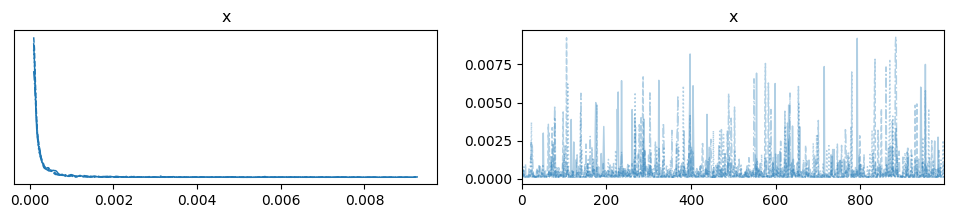

In [16]:
import arviz as az
az.plot_trace(trace, var_names=["x"])